<a href="https://colab.research.google.com/github/xxEthene/ST5225/blob/main/lecture8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing graph-tool (https://graph-tool.skewed.de)

---


To import a library that's not in Colaboratory by default, we can use [condacolab](https://github.com/conda-incubator/condacolab) to install packages from conda.

In [1]:
!pip install -q condacolab
import condacolab
# Workaround issue with Python 3.12:
# condacolab.install()
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


Now we can install conda packages, and we do so for graph-tool.

In [2]:
!mamba install -q graph-tool

warning  libmamba [xorg-xorgproto-2024.1-hb9d3cd8_1] The following files were already present in the environment:
    - include/X11/extensions/EVI.h
    - include/X11/extensions/EVIproto.h
    - include/X11/extensions/ag.h
    - include/X11/extensions/agproto.h
    - include/X11/extensions/cup.h
    - include/X11/extensions/cupproto.h
    - include/X11/extensions/dbe.h
    - include/X11/extensions/dbeproto.h
    - include/X11/extensions/dpmsconst.h
    - include/X11/extensions/dpmsproto.h
    - include/X11/extensions/ge.h
    - include/X11/extensions/geproto.h
    - include/X11/extensions/lbx.h
    - include/X11/extensions/lbxproto.h
    - include/X11/extensions/mitmiscconst.h
    - include/X11/extensions/mitmiscproto.h
    - include/X11/extensions/multibufconst.h
    - include/X11/extensions/multibufproto.h
    - include/X11/extensions/secur.h
    - include/X11/extensions/securproto.h
    - include/X11/extensions/shapeconst.h
    - include/X11/extensions/shapeproto.h
    - include/X11

In [3]:
# Workaround issue with Python 3.12
!mamba install -q scipy

# Now we can use graph-tool as any other Python module

(If a crash occurs at this stage, just run the notebook again... This is related to the kernel switch done by condacolab.)

In [ ]:
from graph_tool.all import *

g = collection.data["celegansneural"]
state = minimize_nested_blockmodel_dl(g)

# Inline drawing works too!

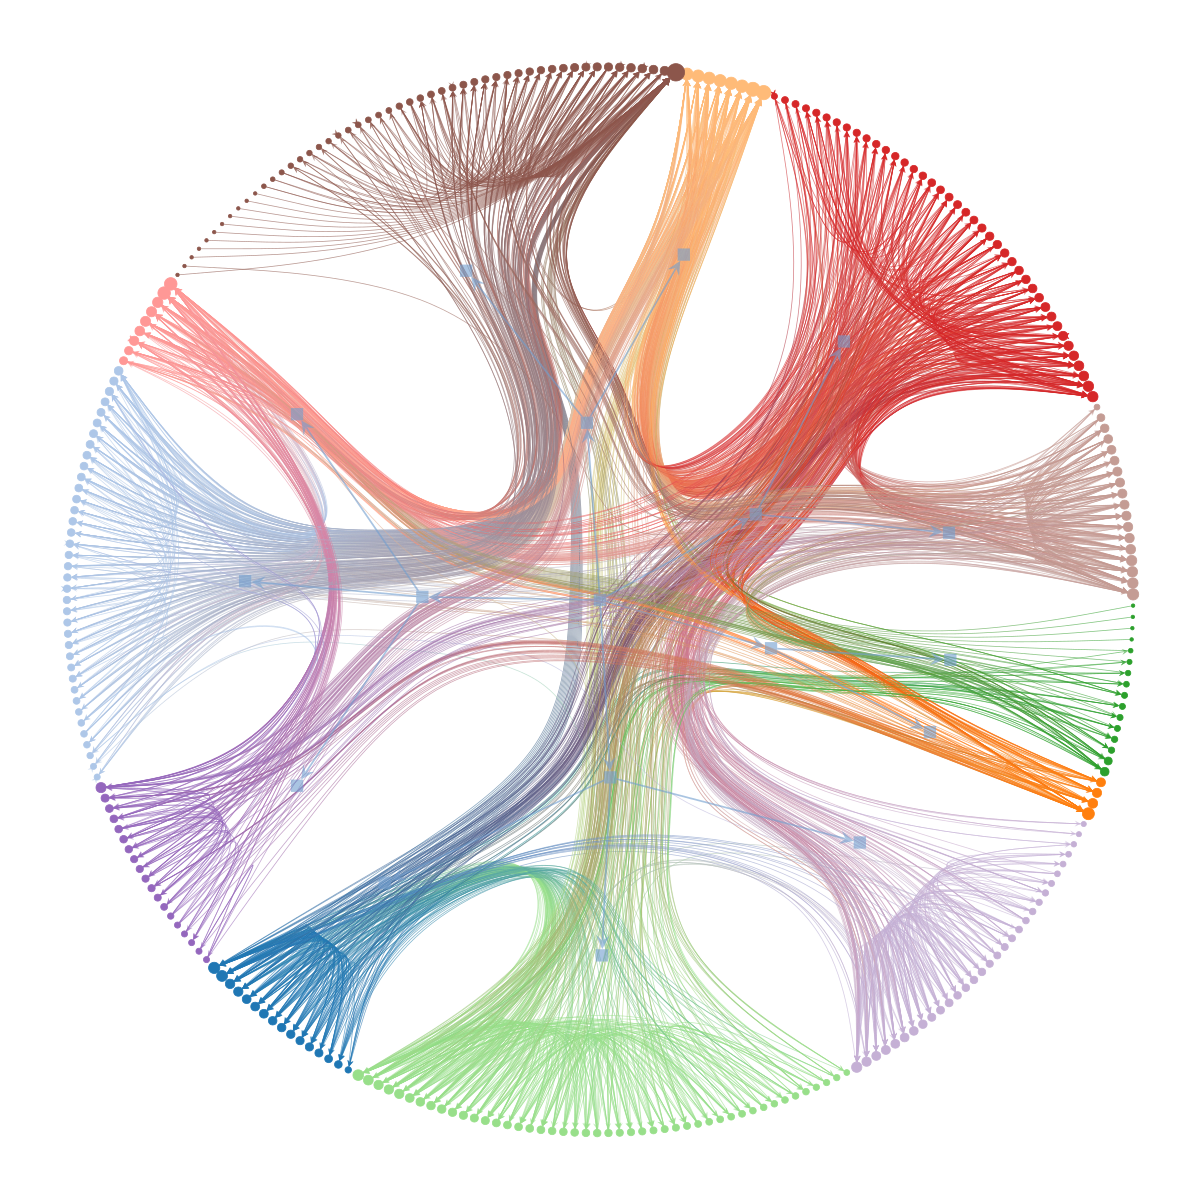

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb1b3175df0, at 0x7fb1b31760c0>,
 <GraphView object, directed, with 315 vertices and 314 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7fb1a4a35280, at 0x7fb1b265f5c0>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7fb1a4a35280, at 0x7fb1a4a34350>, at 0x7fb1a4a35280>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb1a4a35280, at 0x7fb1b261f8c0>)

In [ ]:
state.draw()

Using library: graph-tool


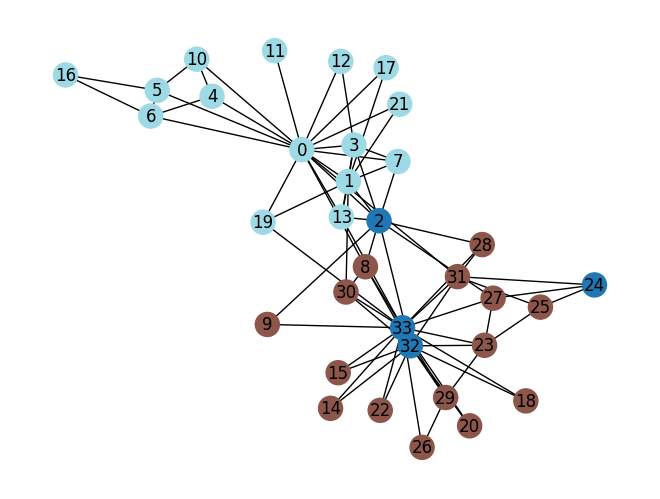

In [3]:
import networkx as nx

def fit_dcsbm(G, q=None, deg_corr=True, lib='graph-tool'):
    """
    Fit a DCSBM to a graph using MLE.

    Parameters:
    - G: An undirected networkx graph.
    - q: Number of blocks to be estimate. If None, the number of blocks is estimated.
    - deg_corr: Whether to use degree correction (that ius, SBM if False, DCSBM if True).
    - lib: The library to use. Either 'graph-tool' or 'graspologic'.

    Returns:
    - labels: A list of block labels. The list is in the same order as the nodes in G.
    """
    print("Using library:", lib)
    if lib == 'graph-tool':
        try:
            import graph_tool.all as gt
            from graph_tool.inference import minimize_blockmodel_dl, BlockState
        except ImportError as e:
            print("`graph-tool` library is not installed. Reverting to `graspologic`.")
            lib = 'graspologic'

    if lib == 'graph-tool':
        # Step 1: Convert the networkx graph to a graph-tool graph
        g = gt.Graph(directed=False)
        g.add_vertex(len(G.nodes))  # Add the nodes 0, 1, n-1, to the graph

        # Step 2: Add the edges to the Graph-tool graph
        v2i = {label: i for i, label in enumerate(G.nodes())}  # This is a mapping from the node labels of G to the node indices in g
        for edge in G.edges():
            g.add_edge(g.vertex(v2i[edge[0]]), g.vertex(v2i[edge[1]]))

        # Step 3: Fit a DCSBM model to the graph using MLE
        if q is None:
            state = minimize_blockmodel_dl(g, state=BlockState, state_args=dict(deg_corr=deg_corr))
        else:
            state = minimize_blockmodel_dl(g, state=BlockState, state_args=dict(deg_corr=deg_corr), multilevel_mcmc_args=dict(B_min=q, B_max=q))

        # Step 4: Extract the inferred block structure
        labels = list(state.get_blocks())
    else:
        import graspologic as gl
        adj_matrix = (nx.to_numpy_array(G) > 0.0)
        if q is None:
            min_comm = 2
            max_comm = 10
        else:
            min_comm = q
            max_comm = q
        if deg_corr:
            model = gl.models.DCSBMEstimator(directed=False, loops=False, min_comm=min_comm, max_comm=max_comm)
        else:
            model = gl.models.SBMEstimator(directed=False, loops=False, min_comm=min_comm, max_comm=max_comm)

        model.fit(adj_matrix)

        labels = model.vertex_assignments_

    # We need to relabel the blocks to have consecutive integers
    label_map = {label: i for i, label in enumerate(set(labels))}
    labels_clean = [label_map[label] for label in labels]
    return labels_clean

# Import the Karate Club graph
karate = nx.karate_club_graph()

# Fit a DCSBM to the graph
labels = fit_dcsbm(karate, q=3, deg_corr=True)

pos = nx.spring_layout(karate, seed=43)
nx.draw(karate, pos, node_color=labels, cmap='tab20', with_labels=True)

In [4]:
# Read the graph from the edge list file
G = nx.read_edgelist("soc-redditHyperlinks-body.tsv", data=False, create_using=nx.Graph())
print(G)

Graph with 12239 nodes and 31954 edges


Using library: graph-tool
4     9507
8      503
3      434
14     410
10     263
15     258
18     209
1      202
17      89
16      85
12      52
7       48
0       47
2       46
9       38
5       24
13      10
6        9
19       3
11       2
Name: count, dtype: int64


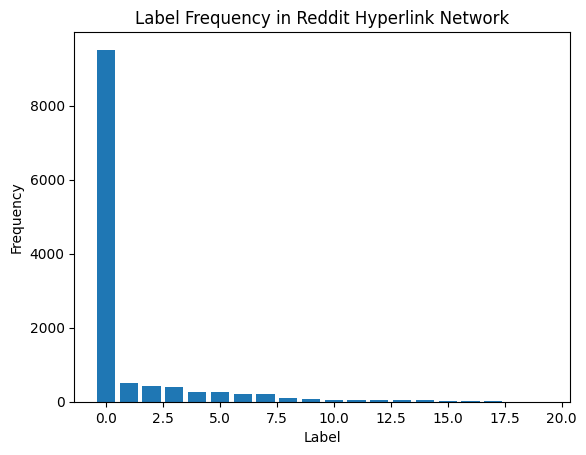

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

labels = fit_dcsbm(G, 20, deg_corr=False)

# Count the number of nodes in each block
label_counts = pd.Series(labels).value_counts() # default is to sort by frequency

print(label_counts)

# Create a bar chart
plt.bar(list(range(len(label_counts))), label_counts.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequency in Reddit Hyperlink Network')

# Show the plot
plt.show()

In [6]:
# Create the block representation of the graph
num_blocks = len(label_counts)
MG_b = nx.MultiGraph()
MG_b.add_nodes_from(range(num_blocks))

# Vertex label to index mapping
v2i = {label: i for i, label in enumerate(G.nodes())}

for edge in G.edges():
    MG_b.add_edge(labels[v2i[edge[0]]], labels[v2i[edge[1]]])

for b in range(num_blocks):
    # Get the nodes in the current block
    block_nodes = [v for v in G.nodes() if labels[v2i[v]] == b]

    # Calculate the total degree of the nodes in the block
    total_degree = sum([G.degree(node) for node in block_nodes])

    MG_b.nodes[b]['total_degree'] = total_degree

# Create a new graph for the block representation
G_b = nx.Graph()

# Iterate over the blocks
for b1 in range(num_blocks):
    for b2 in range(b1, num_blocks):
        # Get the number of edges between the blocks
        num_edges = MG_b.number_of_edges(b1,b2)
        # Calculate the edge weight as the number of edges divided by the maximal number of edges
        if b1 != b2:
            # SBM MLE estimator for the probability of an edge within a block
            edge_weight = num_edges / (label_counts[b1] * label_counts[b2])
            # DCSBM MLE estimator for the probability of an edge within a block
            # edge_weight = num_edges / (MG_b.nodes[b1]['total_degree'] * MG_b.nodes[b2]['total_degree'])
        else:
            if label_counts[b1] > 1:
                # SBM MLE estimator for the probability of an edge within a block
                edge_weight = num_edges / (label_counts[b1] * (label_counts[b1]-1) / 2)
                # DCSBM MLE estimator for the probability of an edge within a block
                # edge_weight = num_edges / (MG_b.nodes[b1]['total_degree'] * (MG_b.nodes[b1]['total_degree']-1)/2)
            else:
                edge_weight = 0

        # Add the edge to the new graph
        G_b.add_edge(b1, b2, weight=edge_weight)

print(G_b)

Graph with 20 nodes and 210 edges


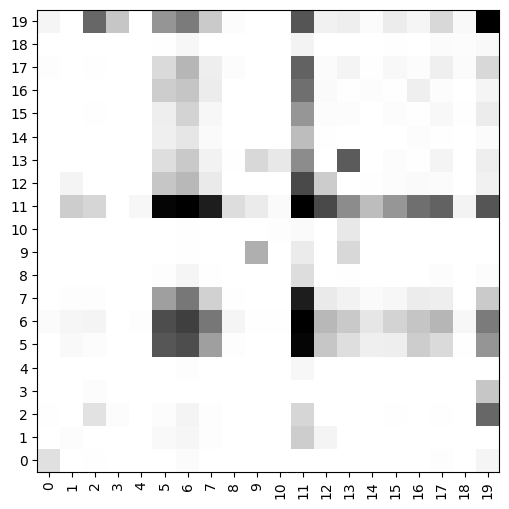

In [7]:
import numpy as np

adj_matrix = nx.adjacency_matrix(G_b, weight='weight').todense()

plt.figure(figsize=(6, 6))
plt.imshow(adj_matrix, cmap='gray_r', interpolation='nearest', extent=(0, 1, 0, 1), origin='lower')

# Set the block numbers as tick labels
num_blocks = len(G_b.nodes())
plt.xticks(ticks=np.linspace(0+1/num_blocks/2, 1-1/num_blocks/2, num_blocks), labels=[v for v in G_b.nodes()], rotation=90)  # Rotate for better visibility
plt.yticks(ticks=np.linspace(0+1/num_blocks/2, 1-1/num_blocks/2, num_blocks), labels=[v for v in G_b.nodes()])

plt.show()

In [8]:
# Calculate the average degree per block
avg_deg = pd.Series()

for b in range(num_blocks):
    # Calculate the average degree per node in the block
    average_degree = MG_b.nodes[b]['total_degree'] / label_counts[b]

    # Append the average degree to the list
    avg_deg[b] = average_degree

    print(f"Block {b:2}: {average_degree:10.2f}")

Block  0:      10.85
Block  1:       8.72
Block  2:      18.24
Block  3:       1.83
Block  4:       1.68
Block  5:     173.17
Block  6:     327.56
Block  7:      80.21
Block  8:      10.09
Block  9:      15.18
Block 10:       4.19
Block 11:     893.00
Block 12:      51.29
Block 13:      73.80
Block 14:       9.27
Block 15:      24.43
Block 16:      31.56
Block 17:      69.61
Block 18:       7.08
Block 19:     239.33


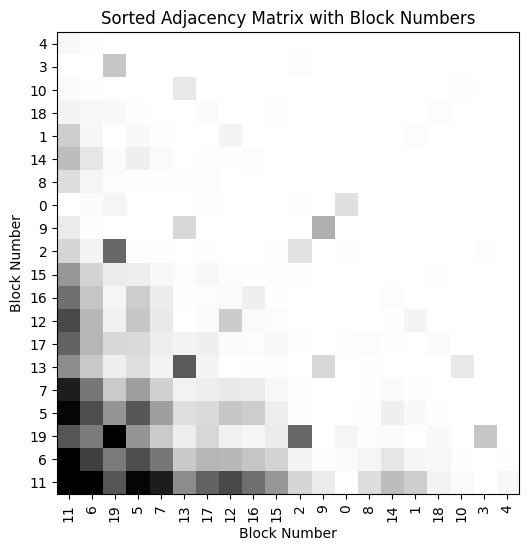

In [9]:
import numpy as np

avg_deg_sort = avg_deg.sort_values(ascending=False)

plt.figure(figsize=(6, 6))
plt.imshow(adj_matrix[:,list(avg_deg_sort.index)][list(avg_deg_sort.index)],
            cmap='gray_r', interpolation='nearest', extent=(0, 1, 0, 1), origin='lower')

# Set the block numbers as tick labels
num_blocks = len(avg_deg_sort)
plt.xticks(ticks=np.linspace(0+1/num_blocks/2, 1-1/num_blocks/2, num_blocks), labels=avg_deg_sort.index, rotation=90)  # Rotate for better visibility
plt.yticks(ticks=np.linspace(0+1/num_blocks/2, 1-1/num_blocks/2, num_blocks), labels=avg_deg_sort.index)

# Add labels and title
plt.xlabel('Block Number')
plt.ylabel('Block Number')
plt.title('Sorted Adjacency Matrix with Block Numbers')

plt.show()

In [11]:
import networkx as nx

G = nx.read_graphml("c.elegans_neural.male_1.graphml").to_undirected()

print(G)

largest_cc = max(nx.connected_components(G), key=len)

G = G.subgraph(largest_cc).copy()

G.remove_edges_from(nx.selfloop_edges(G))

print(G)

Graph with 272 nodes and 2965 edges
Graph with 269 nodes and 2902 edges


In [12]:
import pandas as pd

labels = fit_dcsbm(G, q=11, deg_corr=False)

label_counts = pd.Series(labels).value_counts()

print(label_counts)

Using library: graph-tool
0     47
4     42
1     32
10    30
8     29
5     19
2     17
3     17
9     14
7     11
6     11
Name: count, dtype: int64


In [13]:
communities_paper = {
    0: [
        "vBWM", "PVV", "VD13", "ail/pil", "PVZ", "dgl", "CP04", "DD05", "CP03", "CP02",
        "VA10", "VB09", "VD11", "VB11", "SPDR", "VA12", "CA05", "SPDL", "CA04", "VA11",
        "VD12", "VB10", "VB07", "CP01", "SPVR", "VD09", "VD10", "CA06", "DD04", "VB06",
        "DVC", "VB08", "PVU", "SPVL", "DB05", "CA08", "int", "DD03", "CA09"
    ],
    1: [
        "LUAL", "LUAR", "AVG", "grt/gec/aob/pob", "PCAL", "HOA", "PCAR", "PVNL", "PCBR",
        "R8AR", "PCBL", "R8AL", "R9AL", "R3BR", "R2BR", "DX3", "R8BL", "R9AR", "R2BL",
        "R4BR", "R8BR", "PHBR", "DX1", "R4BL", "CA07", "PHBL", "PHAL", "sph"
    ],
    2: [
        "AVAL", "PVX", "PVY", "AVAR", "DB07", "DB06", "VA09", "DB04", "PVCL", "AVBR",
        "DA06", "PVCR", "DA07", "AVBL", "AS09", "AS10", "DA05", "AVDR", "AS08", "AVDL",
        "DA04", "VB05"
    ],
    3: [
        "dBWM", "DD06", "AS11", "PDC", "PDA", "DA09", "DA08"
    ],
    4: [
        "gonad", "adp/dsp/dsr/vsp", "AVL", "HOB", "CP06", "DVF", "CP05", "SPCR", "SPCL",
        "DVE", "PCCR", "PCCL", "DVB", "CA03", "CA02", "PVT"
    ],
    5: [
        "PDB", "CP07", "R6AR", "R7AR", "CP08", "R7AL", "R6AL", "CP09", "PGA", "R5BL"
    ],
    6: [
        "R9BL", "R7BR", "R1BR", "R7BL", "PVNR", "R5BR", "AN3b", "AN3a", "R6BR", "R9BR",
        "PHAR", "PVS"
    ],
    7: [
        "R3AL", "cdl/pol", "R3AR", "R1AL"
    ],
    8: [
        "R4AL", "R4AR", "R5AL", "R5AR"
    ],
    9: [
        "R2AL", "R2AR", "R1AR"
    ],
    10: [
        "R3BL", "R6BL", "DX2", "R1BL"
    ]
}

In [14]:
from collections import defaultdict

# Map node IDs to their assigned block
node_to_block = dict(zip(G.nodes(), labels))

# Map neuron names to their paper community
paper_communities = {neuron: community for community, neurons in communities_paper.items() for neuron in neurons}

# Initialize comparison dictionary
comparison = defaultdict(lambda: defaultdict(int))

# Iterate over nodes to count assignments
for node in G.nodes():
    name = G.nodes[node]['name']
    if name in paper_communities:
        paper_community = paper_communities[name]
        assigned_block = node_to_block[node]
        comparison[paper_community][assigned_block] += 1

# Print the comparison in increasing order of paper_community
for paper_community in sorted(comparison.keys()):
    block_counts = comparison[paper_community]
    total_nodes = sum(block_counts.values())
    print(f"Paper Community {paper_community} (total of {total_nodes} nodes):")
    for block, count in block_counts.items():
        print(f"  Block {block}: {count} nodes")

Paper Community 0 (total of 29 nodes):
  Block 3: 8 nodes
  Block 9: 1 nodes
  Block 6: 11 nodes
  Block 4: 2 nodes
  Block 5: 4 nodes
  Block 7: 3 nodes
Paper Community 1 (total of 27 nodes):
  Block 0: 1 nodes
  Block 9: 2 nodes
  Block 10: 21 nodes
  Block 3: 1 nodes
  Block 1: 1 nodes
  Block 5: 1 nodes
Paper Community 2 (total of 18 nodes):
  Block 4: 16 nodes
  Block 9: 2 nodes
Paper Community 3 (total of 6 nodes):
  Block 1: 5 nodes
  Block 7: 1 nodes
Paper Community 4 (total of 12 nodes):
  Block 2: 4 nodes
  Block 10: 2 nodes
  Block 3: 4 nodes
  Block 5: 2 nodes
Paper Community 5 (total of 10 nodes):
  Block 9: 1 nodes
  Block 10: 4 nodes
  Block 1: 5 nodes
Paper Community 6 (total of 12 nodes):
  Block 5: 1 nodes
  Block 9: 4 nodes
  Block 1: 6 nodes
  Block 10: 1 nodes
Paper Community 7 (total of 3 nodes):
  Block 1: 3 nodes
Paper Community 8 (total of 4 nodes):
  Block 1: 4 nodes
Paper Community 9 (total of 3 nodes):
  Block 0: 1 nodes
  Block 1: 2 nodes
Paper Community 10

In [15]:
from pathlib import Path
import pandas as pd

# Load all CSVs from data/ into a dict of DataFrames keyed by filename stem
data_dir = Path("Week8_data")
csv_files = sorted(data_dir.glob("*.csv"))

dfs = {f.stem: pd.read_csv(f, index_col=0) for f in csv_files}

# Quick print to show what's loaded
print(list(dfs.keys()))

['Breast_Invasive_Carcinoma', 'Colon_Adenocarcinoma', 'Head_and_Neck_Squamous_Cell_Carcinoma', 'Kidney_Renal_Clear_Cell_Carcinoma', 'Kidney_Renal_Papillary_Cell_Carcinoma', 'Liver_Hepatocellular_Carcinoma', 'Lung_Adenocarcinoma', 'Lung_Squamous_Cell_Carcinoma', 'Prostate_Adenocarcinoma', 'Stomach_Adenocarcinoma', 'Thyroid_Carcinoma', 'Uterine_Corpus_Endometrial_Carcinoma']


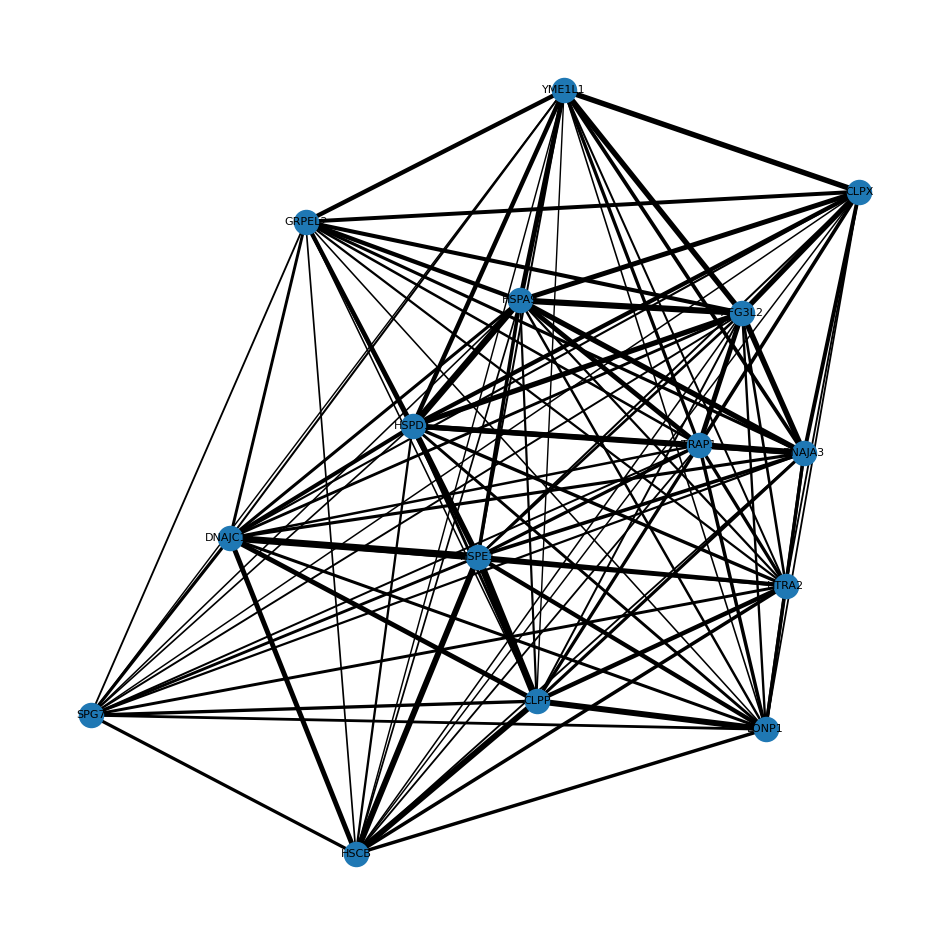

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure all dataframes share the same chaperone index
chaperones_sets = [set(df.index) for df in dfs.values()]
common_chaperones = set.intersection(*chaperones_sets)
assert all(set(df.index) == common_chaperones for df in dfs.values()), "DataFrames do not have the same chaperones"

# Build graph
G = nx.Graph()
G.add_nodes_from(sorted(common_chaperones))

# Compute edge weights: total shared clients across all dataframes
# For each pair of chaperones, count the number of columns where both have a 1 (or nonzero) entry
for a, b in combinations(sorted(common_chaperones), 2):
    weight = 0
    for df in dfs.values():
        # treat non-zero as interaction; adapt if data is boolean/0/1
        row_a = df.loc[a]
        row_b = df.loc[b]
        # If rows are Series aligned by columns, count columns where both non-zero
        shared = ((row_a != 0) & (row_b != 0)).sum()
        weight += int(shared)
    G.add_edge(a, b, weight=weight)

# Visualise
weights = [d['weight'] for u, v, d in G.edges(data=True)]
# scale widths for plotting
max_w = max(weights) if weights else 1
widths = [1 + 4 * (w / max_w) for w in weights]

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=widths)
plt.axis('off')
plt.show()

In [18]:
import pandas as pd
import graph_tool.all as gt
from graph_tool.inference import minimize_blockmodel_dl, BlockState

gt.seed_rng(42)

def fit_dcsbm(G, q=None, deg_corr=True, return_mapping=True):
    """
    Fit a DCSBM to a NetworkX graph using graph-tool.

    Parameters
    ----------
    G : networkx.Graph
        Input graph (nodes can be any hashable labels).
    q : int or None
        If provided, forces the number of blocks.
    deg_corr : bool
        Whether to use degree correction.
    return_mapping : bool
        If True, return a dict mapping original node labels -> block id.

    Returns
    -------
    If return_mapping is True:
        dict: mapping node_label -> inferred block id
    else:
        list: block labels in the order of list(G.nodes())
    """
    # Convert node labels to a stable list and mapping to integer indices
    nodes = list(G.nodes())
    n = len(nodes)
    label_to_index = {label: i for i, label in enumerate(nodes)}

    # Create graph-tool graph with n vertices
    g = gt.Graph(directed=False)
    g.add_vertex(n)

    # Add edges using integer indices
    for u, v in G.edges():
        g.add_edge(g.vertex(label_to_index[u]), g.vertex(label_to_index[v]))

    # Fit the DCSBM
    if q is None:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=dict(deg_corr=deg_corr))
    else:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=dict(deg_corr=deg_corr), multilevel_mcmc_args=dict(B_min=q, B_max=q))

    # Extract block labels (one per vertex in graph-tool order, which matches our nodes list)
    labels = list(state.get_blocks())

    # Normalize labels to 0..K-1
    unique = sorted(set(labels))
    label_map = {lab: i for i, lab in enumerate(unique)}
    normalized = [label_map[lab] for lab in labels]

    if return_mapping:
        # build dict node_label -> block id
        return {node: normalized[i] for i, node in enumerate(nodes)}
    else:
        return normalized

In [19]:
fit_dcsbm(G, q=2, deg_corr=False)

{'AFG3L2': 0,
 'CLPP': 0,
 'CLPX': 0,
 'DNAJA3': 0,
 'DNAJC19': 0,
 'GRPEL2': 0,
 'HSCB': 0,
 'HSPA9': 0,
 'HSPD1': 1,
 'HSPE1': 0,
 'HTRA2': 0,
 'LONP1': 0,
 'SPG7': 0,
 'TRAP1': 0,
 'YME1L1': 0}

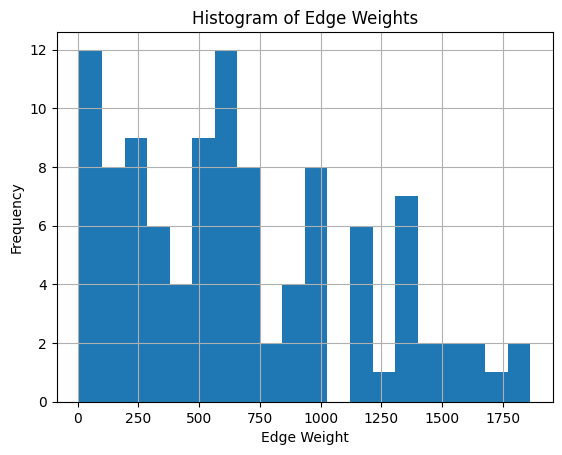

In [20]:
# Draw historgram of edge weights
weights = [d['weight'] for u, v, d in G.edges(data=True)]
pd.Series(weights).hist(bins=20)
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.title("Histogram of Edge Weights")
plt.show()

In [21]:
# Remove all edges the weight of which is below 400
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 500]
G.remove_edges_from(edges_to_remove)

fit_dcsbm(G, q=2,deg_corr=False)

{'AFG3L2': 0,
 'CLPP': 1,
 'CLPX': 0,
 'DNAJA3': 0,
 'DNAJC19': 1,
 'GRPEL2': 0,
 'HSCB': 1,
 'HSPA9': 0,
 'HSPD1': 0,
 'HSPE1': 1,
 'HTRA2': 1,
 'LONP1': 1,
 'SPG7': 1,
 'TRAP1': 0,
 'YME1L1': 0}

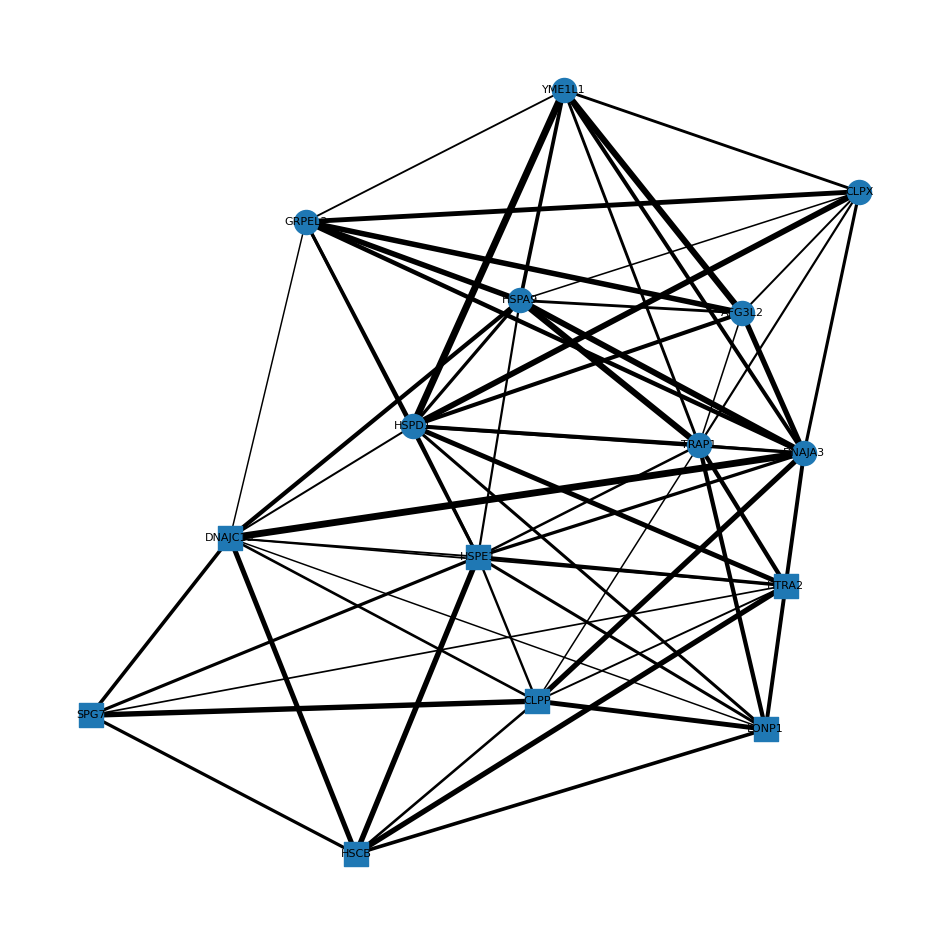

In [22]:
# Get community assignments
community_map = fit_dcsbm(G, q=2, deg_corr=False)
communities = list(community_map.values())
shapes = ['o' if c == 0 else 's' for c in communities]
# Visualise with community shapes
plt.figure(figsize=(12, 12))
for shape in set(shapes):
    nodes_of_shape = [node for node, shp in zip(G.nodes(), shapes) if shp == shape]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_of_shape, node_shape=shape, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=widths)
plt.axis('off')
plt.show()

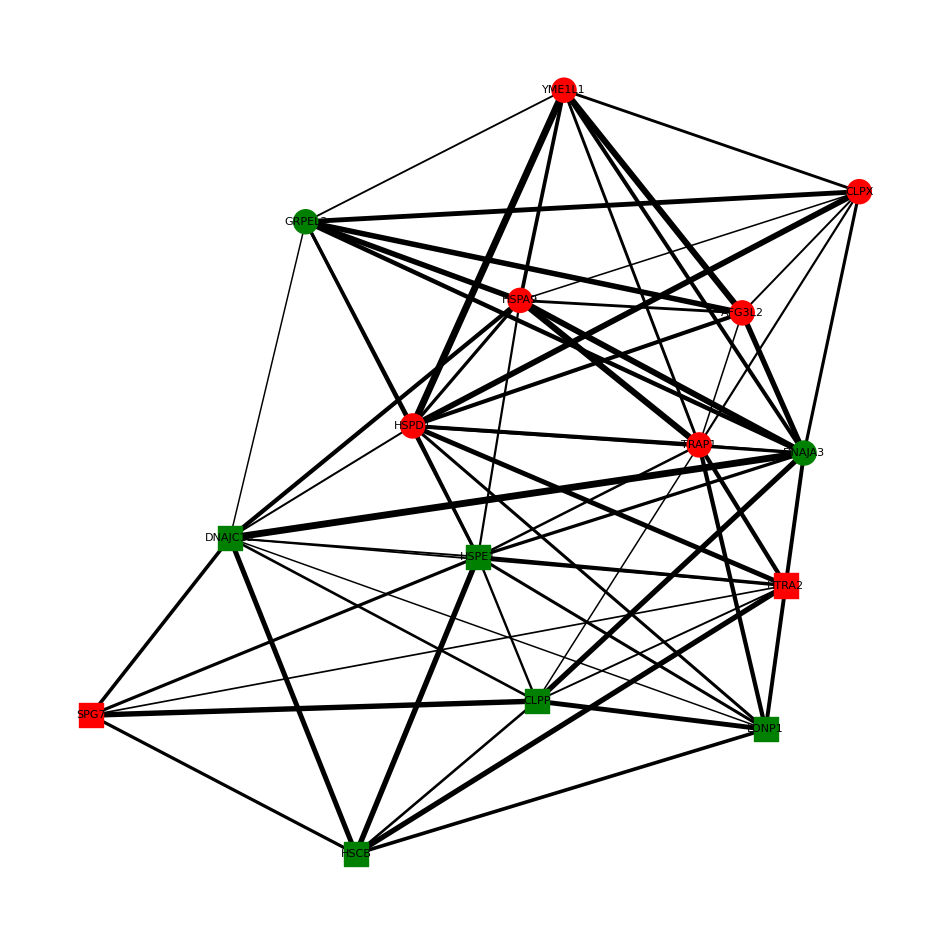

In [23]:
# Encode chaperones (black) and co-chaperones (blue) extracted from the PNG
chaperones_list = [
    'HSPD1', 'HSPA9', 'CLPX', 'TRAP1', 'AFG3L2', 'YME1L1', 'HTRA2', 'SPG7'
]
cochaperones_list = [
    'DNAJA3', 'GRPEL2', 'HSPE1', 'LONP1', 'CLPP', 'HSCB', 'DNAJC19'
]

# Assign colors based on ground truth
color_map = {}
for node in G.nodes():
    if node in chaperones_list:
        color_map[node] = 'red'
    elif node in cochaperones_list:
        color_map[node] = 'green'
    else:
        color_map[node] = 'gray'  # for any unexpected nodes

# Visualise with ground truth colors and shapes from SBM
plt.figure(figsize=(12, 12))
for shape in set(shapes):
    nodes_of_shape = [node for node, shp in zip(G.nodes(), shapes) if shp == shape]
    node_colors = [color_map[node] for node in nodes_of_shape]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_of_shape, node_shape=shape, node_color=node_colors, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=widths)
plt.axis('off')
plt.show()

In [26]:
import pandas as pd

# Load files from the data directory
# specify latin1 encoding to avoid UnicodeDecodeError on some CSV files
df_countries = pd.read_csv('Initial_data_all_countrys.csv', encoding='latin1')
df_codes = pd.read_excel('country_codes.xlsx')

# Merge country names into the main dataframe
df_countries = pd.merge(df_countries, df_codes, left_on='ReporterISO3', right_on='Country code', how='left').rename(columns={'Country Name': 'ReporterName_full'})
df_countries = pd.merge(df_countries, df_codes, left_on='PartnerISO3', right_on='Country code', how='left').rename(columns={'Country Name': 'PartnerName_full'})


# Show first few rows
print('Initial_data_all_countrys.csv - head:')
print(df_countries.head())

print('country_codes.xlsx - head:')
print(df_codes.head())

Initial_data_all_countrys.csv - head:
  Nomenclature ReporterISO3 ProductCode ReporterName PartnerISO3  PartnerName  \
0           H5          AGO       Total       Angola         ABW        Aruba   
1           H5          AGO       Total       Angola         AFG  Afghanistan   
2           H5          AGO       Total       Angola         AFG  Afghanistan   
3           H5          AGO       Total       Angola         AGO       Angola   
4           H5          AGO       Total       Angola         AIA      Anguila   

  TradeFlowName  TradeFlowCode  2018 in 1000 USD  2019 in 1000 USD  \
0        Import              5               NaN            10.898   
1        Export              6            19.353               NaN   
2        Import              5           117.812             2.392   
3        Import              5               NaN               NaN   
4        Import              5               NaN               NaN   

   2020 in 1000 USD  2021 in 1000 USD  2022 in 1000 US

In [27]:
# Build 2018 export network
import networkx as nx

# Filter exports for 2018
df_2018_exports = df_countries[df_countries['TradeFlowName'] == 'Export']

# Take relevant columns and drop rows with missing ISO codes or values
edges_2018 = df_2018_exports[['ReporterName_full', 'PartnerName_full', '2018 in 1000 USD']].dropna()

G2018 = nx.DiGraph()

# Add nodes (all country names seen as reporters or partners)
countries = pd.unique(edges_2018[['ReporterName_full', 'PartnerName_full']].values.ravel('K'))
G2018.add_nodes_from(countries)

# Add edges with weight equal to the 2018 trade value
for _, row in edges_2018.iterrows():
    src = row['ReporterName_full']
    tgt = row['PartnerName_full']
    weight = row['2018 in 1000 USD']
    # Error message if multiple edges
    if G2018.has_edge(src, tgt):
        print(f'Error: Multiple trade entries from {src} to {tgt}. Summing weights.')
        G2018[src][tgt]['weight'] += weight
    else:
        G2018.add_edge(src, tgt, weight=weight)

print(f"2018 export network: {G2018.number_of_nodes()} nodes, {G2018.number_of_edges()} edges")

# Show top 10 edges by weight
top_edges = sorted(G2018.edges(data=True), key=lambda e: e[2].get('weight', 0), reverse=True)[:10]
print("Top 10 export edges by 2018 value (in 1000 USD):")
for u, v, d in top_edges:
    print(u, '->', v, ':', d['weight'])

2018 export network: 186 nodes, 16357 edges
Top 10 export edges by 2018 value (in 1000 USD):
China -> United States of America : 479278747.159
Canada -> United States of America : 307704783.229
United States of America -> Canada : 247741950.531
United States of America -> Mexico : 203972907.19
Republic of Korea -> China : 162124667.641
China -> Japan : 147048752.77
Japan -> China : 144033051.527
Japan -> United States of America : 140713379.457
Germany -> United States of America : 134363438.749
Netherlands -> Germany : 133402354.614


In [28]:
# DCSBM fitting utility (returns mapping/labels, dof, log-likelihood, and BIC)
import math
import networkx as nx
import pandas as pd
import graph_tool.all as gt
from graph_tool.inference import minimize_blockmodel_dl, BlockState

gt.seed_rng(42)


def fit_dcsbm(G, q=None, deg_corr=True, return_mapping=True):
    """
    Fit a DCSBM to a NetworkX graph using graph-tool, and return basic model metrics.

    Parameters
    ----------
    G : networkx.Graph or DiGraph
        Input graph (nodes can be any hashable labels). If directed, it is treated as undirected.
    q : int or None
        If provided, forces the number of blocks (BIC/LL computed for that fixed B).
    deg_corr : bool
        Whether to use degree correction.
    return_mapping : bool
        If True, return a dict mapping original node labels -> block id; otherwise
        return the list of block labels in the order of list(G.nodes()).

    Returns
    -------
    If return_mapping is True:
        mapping, q, n_params, n_obs, log_likelihood, bic
    else:
        labels, q, n_params, n_obs, log_likelihood, bic
    """
    # Stable node order and label->index mapping
    nodes = list(G.nodes())
    n = len(nodes)
    label_to_index = {label: i for i, label in enumerate(nodes)}

    # Use an undirected simple representation for the DCSBM fit
    if hasattr(G, 'is_directed') and G.is_directed():
        edge_iter = nx.Graph(G).edges()
    else:
        edge_iter = G.edges()

    # Build graph-tool graph
    g = gt.Graph(directed=False)
    g.add_vertex(n)

    for u, v in edge_iter:
        g.add_edge(g.vertex(label_to_index[u]), g.vertex(label_to_index[v]))

    if q is None:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=dict(deg_corr=deg_corr))
    else:
        state = minimize_blockmodel_dl(g, state=BlockState, state_args=dict(deg_corr=deg_corr), multilevel_mcmc_args=dict(B_min=q, B_max=q))

    # Extract block labels in the same order as `nodes`
    labels = list(state.get_blocks())

    # Normalize labels
    unique = sorted(set(labels))
    q = len(unique) # state.get_B() doesn't seem to work properly
    label_map = {lab: i for i, lab in enumerate(unique)}
    normalized = [label_map[lab] for lab in labels]

    # Compute model metrics
    block_params = q * (q + 1) // 2
    theta_params = (n - q) if deg_corr else 0
    n_params = block_params + theta_params
    n_obs = max((n * (n - 1)) // 2, 1)  # number of potential dyads

    # Use the state description length (in nats) as -log-likelihood proxy
    dl = float(state.entropy())  # description length (MDL) in nats
    log_likelihood = -dl

    # Sample size: number of potential dyads for an undirected simple graph
    # If you switch to a directed model, use n*(n-1) instead.
    bic = n_params * math.log(n_obs) - 2.0 * log_likelihood

    if return_mapping:
        mapping = {node: normalized[i] for i, node in enumerate(nodes)}
        return mapping, q, n_params, n_obs, log_likelihood, bic
    else:
        return normalized, q, n_params, n_obs, log_likelihood, bic

In [29]:
# Fit plain SBM with k=4 to the 2018 export network and print results
# Treat the directed network as undirected for the SBM fit
G2018_und = nx.Graph(G2018)

mapping, q, n_params, n_obs, log_likelihood, bic = fit_dcsbm(G2018_und, q=4, deg_corr=False, return_mapping=True)

print("Number of blocks:", q)
print("Number of parameters:", n_params)
print("Number of observations:", n_obs)
print("Log-likelihood:", log_likelihood)
print("BIC:", bic)

# Community sizes
from collections import Counter
sizes = Counter(mapping.values())
print("Community sizes (block_id -> count):")
for k in sorted(sizes):
    print(k, '->', sizes[k])

Number of blocks: 4
Number of parameters: 10
Number of observations: 17205
Log-likelihood: -13920.050367857511
BIC: 27937.63028889734
Community sizes (block_id -> count):
0 -> 60
1 -> 42
2 -> 74
3 -> 10


In [31]:
# Create a DataFrame with country, community, and degree
results_2018 = pd.DataFrame({
    'Country': list(mapping.keys()),
    'Community': list(mapping.values())
})

# Add degree to the DataFrame
degrees = dict(G2018_und.degree())
results_2018['Degree'] = results_2018['Country'].map(degrees)

# Merge with df_codes to get full country names
results_2018 = pd.merge(results_2018, df_codes, left_on='Country', right_on='Country Name', how='left')

# Group by community and analyze
for i in range(q):
    community_df = results_2018[results_2018['Community'] == i]
    mean_degree = community_df['Degree'].mean()

    print(f"\n--- Community {i} ---")
    print(f"Mean Degree: {mean_degree:.2f}")

    # Sort by degree and get the top 5
    top_countries = community_df.sort_values(by='Degree', ascending=False).head(5)
    print("Most connected countries:")
    print(top_countries[['Country Name', 'Degree']].to_string(index=False))


--- Community 0 ---
Mean Degree: 80.23
Most connected countries:
Country Name  Degree
       Egypt     111
Saudi Arabia     111
      Mexico     109
 Philippines     109
     Ukraine     109

--- Community 1 ---
Mean Degree: 115.48
Most connected countries:
Country Name  Degree
      Angola     141
     Myanmar     136
   Guatemala     135
  Madagascar     135
      Israel     135

--- Community 2 ---
Mean Degree: 168.51
Most connected countries:
            Country Name  Degree
                   China     185
             Switzerland     185
             Netherlands     185
United States of America     185
                Thailand     185

--- Community 3 ---
Mean Degree: 39.20
Most connected countries:
   Country Name  Degree
        Vanuatu      52
          Samoa      45
          Palau      44
         Bhutan      42
Solomon Islands      42


In [32]:
# --- Full Analysis for 2022 ---

# 1. Build 2022 export network
df_2022_exports = df_countries[df_countries['TradeFlowName'] == 'Export']
edges_2022 = df_2022_exports[['ReporterName_full', 'PartnerName_full', '2022 in 1000 USD']].dropna()

G2022 = nx.DiGraph()
countries_2022 = pd.unique(edges_2022[['ReporterName_full', 'PartnerName_full']].values.ravel('K'))
G2022.add_nodes_from(countries_2022)

for _, row in edges_2022.iterrows():
    src = row['ReporterName_full']
    tgt = row['PartnerName_full']
    weight = row['2022 in 1000 USD']
    if G2022.has_edge(src, tgt):
        G2022[src][tgt]['weight'] += weight
    else:
        G2022.add_edge(src, tgt, weight=weight)

print(f"2022 export network: {G2022.number_of_nodes()} nodes, {G2022.number_of_edges()} edges")

# 2. Fit plain SBM with k=4
G2022u = nx.Graph(G2022)
mapping_2022, q_2022, _, _, _, _ = fit_dcsbm(G2022u, q=4, deg_corr=False, return_mapping=True)

# 3. Create DataFrame and analyze communities
results_2022 = pd.DataFrame({
    'Country': list(mapping_2022.keys()),
    'Community': list(mapping_2022.values())
})

degrees_2022 = dict(G2022u.degree())
results_2022['Degree'] = results_2022['Country'].map(degrees_2022)

results_2022 = pd.merge(results_2022, df_codes, left_on='Country', right_on='Country Name', how='left')

print("\n--- Community Analysis for 2022 ---")
for i in range(q_2022):
    community_df = results_2022[results_2022['Community'] == i]
    mean_degree = community_df['Degree'].mean()

    print(f"\n--- Community {i} ---")
    print(f"Mean Degree: {mean_degree:.2f}")

    top_countries = community_df.sort_values(by='Degree', ascending=False).head(5)
    print("Most connected countries:")
    print(top_countries[['Country Name', 'Degree']].to_string(index=False))

2022 export network: 186 nodes, 17276 edges

--- Community Analysis for 2022 ---

--- Community 0 ---
Mean Degree: 176.54
Most connected countries:
  Country Name  Degree
       Belgium     185
         Spain     185
United Kingdom     185
         China     185
         India     185

--- Community 1 ---
Mean Degree: 125.33
Most connected countries:
Country Name  Degree
   Argentina     157
       Ghana     155
     Tunisia     153
       Malta     151
        Peru     151

--- Community 2 ---
Mean Degree: 46.62
Most connected countries:
         Country Name  Degree
Saint Kitts and Nevis      60
     Marshall Islands      59
              Eritrea      54
          South Sudan      54
           San Marino      53

--- Community 3 ---
Mean Degree: 83.47
Most connected countries:
      Country Name  Degree
      Saudi Arabia     120
Russian Federation     117
        Bangladesh     111
           Algeria     106
            Uganda     104


In [33]:
# Merge 2018 and 2022 results
comparison_df = pd.merge(
    results_2018,
    results_2022,
    on='Country',
    suffixes=['_2018', '_2022']
)

# Create contingency table
contingency_table = pd.crosstab(comparison_df['Community_2018'], comparison_df['Community_2022'])

print("Original Contingency Table:")
print(contingency_table)

# Find best permutation of 2022 labels to maximize diagonal
from scipy.optimize import linear_sum_assignment

cost_matrix = -contingency_table.values
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create the reordered contingency table
reordered_table = contingency_table.iloc[row_ind, col_ind]

print("\nReordered Contingency Table (maximized diagonal):")
print(reordered_table)

Original Contingency Table:
Community_2022   0   1   2   3
Community_2018                
0                5  14   6  35
1                1  33   0   8
2               51  19   0   4
3                0   0  10   0

Reordered Contingency Table (maximized diagonal):
Community_2022   3   1   0   2
Community_2018                
0               35  14   5   6
1                8  33   1   0
2                4  19  51   0
3                0   0   0  10


In [34]:
from sklearn.metrics import adjusted_rand_score
# Calculate Adjusted Rand Index
ari = adjusted_rand_score(comparison_df['Community_2018'], comparison_df['Community_2022'])
print(f"\nAdjusted Rand Index (ARI) between 2018 and 2022 community assignments: {ari:.4f}")


Adjusted Rand Index (ARI) between 2018 and 2022 community assignments: 0.3373
